In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
from os.path import exists
from os import remove
import sklearn.linear_model as lm
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
import sklearn.model_selection as ms
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import sys
sys.path.insert(0, "../util/")
import util as util

/Users/garysimmons/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (36,40,81,87) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


# Add Dummies and Train-Test-Split

In [2]:
housingTrainWithDummiesExists = exists('../data/housingTrainWithDummies.csv')
housingTestWithDummiesExists = exists('../data/housingTestWithDummies.csv')
housingTrainWithoutDummiesExists = exists('../data/housingTrainWithoutDummies.csv')
housingTestWithoutDummiesExists = exists('../data/housingTestWithoutDummies.csv')
relatedDummiesDictionaryExists = exists('../data/relatedDummiesDictionary.json')

if (housingTrainWithDummiesExists and housingTestWithDummiesExists and
   housingTrainWithoutDummiesExists and housingTestWithoutDummiesExists and
   relatedDummiesDictionaryExists):
    housingTrainWithDummies = pd.read_csv('../data/housingTrainWithDummies.csv')
    housingTestWithDummies = pd.read_csv('../data/housingTestWithDummies.csv')
    housingTrainWithoutDummies = pd.read_csv('../data/housingTrainWithoutDummies.csv')
    housingTestWithoutDummies = pd.read_csv('../data/housingTestWithoutDummies.csv')
    with open('../data/relatedDummiesDictionary.json') as d:
        relatedDummiesDictionary = json.load(d)
    for df in [housingTrainWithDummies,housingTestWithDummies,housingTrainWithoutDummies,housingTestWithoutDummies]:
        df["MSSubClass"] = df["MSSubClass"].apply(str)
        df["MoSold"] = df["MoSold"].apply(str)
    
else:
    if (housingTrainWithDummiesExists):
        remove('../data/housingTrainWithDummies.csv')
    if (housingTestWithDummiesExists):
        remove('../data/housingTestWithDummies.csv')
    if (housingTrainWithoutDummiesExists):
        remove('../data/housingTrainWithoutDummies.csv')
    if (housingTestWithoutDummiesExists):
        remove('../data/housingTestWithoutDummies.csv')
    if (relatedDummiesDictionaryExists):
        remove('../data/relatedDummiesDictionary.json')
    
    amesHousing = pd.read_csv('../data/Ames_Housing_Price_Data.csv')   
    
    amesHousing['MSSubClass'] = amesHousing['MSSubClass'].apply(str)
    amesHousing['MoSold'] = amesHousing['MoSold'].apply(str)
    
    amesHousingCategoricalData = amesHousing.select_dtypes(include=['O'])
    for col in amesHousingCategoricalData.columns:
        amesHousing[col]=amesHousing[col].fillna('nan')
    relatedDummiesDictionary = {}
    for col in amesHousingCategoricalData.columns:
        dummyData = pd.get_dummies(amesHousing[col],prefix=col,drop_first=True)
        for dummyCol in dummyData.columns:
            relatedDummiesDictionary[str(dummyCol)] = list(dummyData.columns)
        amesHousing = pd.concat([amesHousing,dummyData],axis=1)
    with open('../data/relatedDummiesDictionary.json', 'w') as fp:
        json.dump(relatedDummiesDictionary, fp)
    
    salesPrice = amesHousing['SalePrice']
    X = amesHousing.drop(['SalePrice'], axis=1)
    
    housingTrainWithDummies, housingTestWithDummies, salesPriceTrain, salesPriceTest = train_test_split(X, salesPrice, test_size=0.2)
    
    housingTrainWithDummies['SalePrice'] = salesPriceTrain
    housingTestWithDummies['SalePrice'] = salesPriceTest
    
    dummyColumns = list(relatedDummiesDictionary.keys())
    housingTrainWithoutDummies = housingTrainWithDummies.drop(dummyColumns, axis=1)
    housingTestWithoutDummies = housingTestWithDummies.drop(dummyColumns, axis=1)
    
    housingTrainWithDummies.to_csv('../data/housingTrainWithDummies.csv',index=False)
    housingTestWithDummies.to_csv('../data/housingTestWithDummies.csv',index=False)
    housingTrainWithoutDummies.to_csv('../data/housingTrainWithoutDummies.csv',index=False)
    housingTestWithoutDummies.to_csv('../data/housingTestWithoutDummies.csv',index=False)

/Users/garysimmons/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (8,73) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
if (("ISUDistance" not in housingTrainWithoutDummies.columns) or 
    ("ISUDistance" not in housingTrainWithDummies.columns)):
    housingTrainWithoutDummies = util.returnDFWithISUDistance(housingTrainWithoutDummies,True)
    housingTrainWithDummies["ISUDistance"] = housingTrainWithoutDummies["ISUDistance"]
    housingTrainWithDummies.to_csv('../data/housingTrainWithDummies.csv',index=False)
    housingTrainWithoutDummies.to_csv('../data/housingTrainWithoutDummies.csv',index=False)

# Training

## Linear Regression

In [4]:
housingTrainNumerical = housingTrainWithDummies.select_dtypes(include=['uint8','int64','float64'])

In [5]:
if (exists('../data/trainNanReplacementValuesDictionary.json')):
    with open('../data/trainNanReplacementValuesDictionary.json') as d:
        trainNanReplacementValuesDictionary = json.load(d)
else:
    trainNanReplacementValuesDictionary = {}
    for col in housingTrainNumerical:
        if col in ["YearBuilt","YearRemodAdd","GarageYrBlt","YrSold","ISUDistance"]:
            trainNanReplacementValuesDictionary[str(col)] = housingTrainNumerical[col].mean()
        elif col in ["OverallQual","OverallCond"]:
            trainNanReplacementValuesDictionary[str(col)] = round(np.mean(housingTrainNumerical[col].mode().values))
        else:
            trainNanReplacementValuesDictionary[str(col)] = 0
    with open('../data/trainNanReplacementValuesDictionary.json', 'w') as fp:
        json.dump(trainNanReplacementValuesDictionary, fp)
    

In [6]:
housingTrainNumerical = util.replaceNansWithTrainingDataValues(housingTrainNumerical)

../util/util.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(trainNanReplacementValuesDictionary[str(col)])


In [7]:
salesPrice = housingTrainNumerical["SalePrice"]
X = housingTrainNumerical.drop(['SalePrice'], axis=1)

In [8]:
X.shape

(2064, 296)

In [9]:
initialAlpha = [1]+list(np.linspace(50,1000,20))

In [10]:
grid_para_elsatic_net_initial = {'alpha': initialAlpha, 'l1_ratio': np.linspace(0,1,11)}

In [11]:
elasticNet = ElasticNet()
if False:
    grid_search_elastic_net = ms.GridSearchCV(elasticNet, grid_para_elsatic_net_initial, scoring='accuracy', cv=5, n_jobs=-1, return_train_score=True)
    grid_search_elastic_net.fit(X,salesPrice)
    grid_search_elastic_net.best_params_

In [12]:
finalAlpha = [1] + list(np.linspace(5,50,10))

In [13]:
grid_para_elsatic_net_final = {'alpha': finalAlpha, 'l1_ratio': [0.0]}

In [14]:
grid_search_elastic_net = ms.GridSearchCV(elasticNet, grid_para_elsatic_net_final, scoring='accuracy', cv=5, n_jobs=-1, return_train_score=True)
grid_search_elastic_net.fit(X,salesPrice)
grid_search_elastic_net.best_params_

/Users/garysimmons/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/Users/garysimmons/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/Users/garysimmons/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 913291954651.0177, tolerance: 1164331462.278763
  model = cd_fast.enet_coordinate_descent(


{'alpha': 1, 'l1_ratio': 0.0}

In [15]:
if exists('../data/sigCorrDictionary.json'):
    with open('../data/sigCorrDictionary.json') as d:
        sigCorrDictionary = json.load(d)
else:
    !rm -r ../images/sigCorrs
    !mkdir ../images/sigCorrs
    correlationList = []
    iColumnList = []
    jColumnList = []
    pValList = []
    for i in range(len(X.columns)):
        for j in range(len(X.columns)):
            if i<j:
                iColumn = X.columns[i]
                jColumn = X.columns[j]
                iColumnList.append(iColumn)
                jColumnList.append(jColumn)
                corrVal,pVal = stats.spearmanr(X[iColumn],
                                              X[jColumn])
                correlationList.append(corrVal)
                pValList.append(pVal)

    amesHousingCorreltaion = pd.DataFrame({"iColumn":iColumnList,
                                    "jColumn":jColumnList,
                                    "corr":correlationList,
                                    "pVal":pValList
                                   },columns=["iColumn","jColumn","corr","pVal"]).sort_values(by=["pVal","corr"],
                                                                                 ascending=[True,False])

    amesHousingSigCorrs = amesHousingCorreltaion[(np.isnan(amesHousingCorreltaion['pVal'])==False) & (amesHousingCorreltaion['pVal'] < 0.05)]
    absRValues = abs(amesHousingSigCorrs['corr'])
    amesHousingSigCorrs = amesHousingSigCorrs[abs(amesHousingSigCorrs['corr']) > absRValues.quantile(.975)]

    sigCorrDictionary = {}
    iColumns = list(amesHousingSigCorrs["iColumn"])
    jColumns = list(amesHousingSigCorrs["jColumn"])
    for col in X.columns:
        correlatedColumns = []
        for i,iCol in enumerate(iColumns):
            if iCol == col:
                correlatedColumns.append(jColumns[i])
        for j,jCol in enumerate(jColumns):
            if jCol == col:
                correlatedColumns.append(iColumns[j])
        relatedDummies = []
        for corrCol in correlatedColumns:
            util.plotCorrelation(X[col],X[corrCol],f'{col}-{corrCol}')
            if corrCol in relatedDummiesDictionary.keys():
                relatedDummies = relatedDummies + relatedDummiesDictionary[corrCol]
        correlatedColumns = list(set(correlatedColumns + relatedDummies))
        sigCorrDictionary[col] = correlatedColumns
    with open('../data/sigCorrDictionary.json', 'w') as fp:
        json.dump(sigCorrDictionary, fp)

In [16]:
baseV1 = pd.DataFrame()
prebaseV2 = pd.DataFrame()
baseV2 = pd.DataFrame()

linmodel = lm.LinearRegression()
linmodel.fit(np.log(X[['GrLivArea']]),np.log(salesPrice))
baseV1[f'GrLivArea^{round(linmodel.coef_[0],2)}'] = X['GrLivArea'] ** round(linmodel.coef_[0],2)

linmodel = lm.LinearRegression()
XWithNeighborhood = pd.merge(X,housingTrainWithDummies[["PID","Neighborhood"]],how='left', left_on='PID', right_on='PID')
Nbr_quantile = XWithNeighborhood.groupby('Neighborhood')['GrLivArea'].quantile(0.8)
joint_Nbr_quantile = pd.merge(XWithNeighborhood[['Neighborhood']], Nbr_quantile, how='left', left_on='Neighborhood', right_index=True)
smaller_home = XWithNeighborhood.GrLivArea < joint_Nbr_quantile.GrLivArea

small = []
large = []
for i,isSmall in enumerate(smaller_home):
    if isSmall:
        small.append(XWithNeighborhood.GrLivArea[i])
        large.append(0)
    else:
        small.append(0)
        large.append(XWithNeighborhood.GrLivArea[i])
linmodel.fit(np.log(XWithNeighborhood[["GrLivArea"]])[smaller_home],np.log(salesPrice)[smaller_home.values])
baseV2[f'smallGrLivArea^{round(linmodel.coef_[0],2)}'] = small ** round(linmodel.coef_[0],2)
linmodel.fit(np.log(XWithNeighborhood[["GrLivArea"]])[~smaller_home],np.log(salesPrice)[~smaller_home.values])
baseV2[f'largeGrLivArea^{round(linmodel.coef_[0],2)}'] = large ** round(linmodel.coef_[0],2)

In [17]:
elasticNet = ElasticNet(alpha=1000,l1_ratio=0.0)
results = cross_validate(elasticNet,baseV1,salesPrice)
np.mean(results['test_score'])

/Users/garysimmons/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2239794095782.0884, tolerance: 901420132.812253
  model = cd_fast.enet_coordinate_descent(
/Users/garysimmons/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2466411069760.274, tolerance: 998562609.9990066
  model = cd_fast.enet_coordinate_descent(
/Users/garysimmons/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2181102078453.953, tolerance: 877027398.0896965
  model = cd_fast.enet_coordinate_descent(
/Users/garysimmons/opt/anaconda3/lib/python3.8/site-pac

0.5109026476462587

In [18]:
elasticNet = ElasticNet(alpha=1000,l1_ratio=0.5)
results = cross_validate(elasticNet,baseV2,salesPrice)
np.mean(results['test_score'])

0.541779684831709

In [19]:
availabilityList = list(X.columns)

In [20]:
availabilityList = util.removeDummiesAndCorrelatedFeaturesFromAvailabilityList(availabilityList,"GrLivArea")

In [21]:
f_value,p_value = f_regression(X,salesPrice)
fValuesSorted = pd.DataFrame({"colName":list(X.columns),
                             "f_value":f_value},
                            columns=["colName","f_value"]).sort_values(by=["f_value"],
                                                                                 ascending=[False])

/Users/garysimmons/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [22]:
xTrain = baseV2
elasticNet = ElasticNet(alpha=1000,l1_ratio=0.5)
results = cross_validate(elasticNet,xTrain,salesPrice,return_train_score=True)
trainScore = np.mean(results['train_score'])
testScore = np.mean(results['test_score'])
bestScore = testScore
modelEvolution = pd.DataFrame({"features":["\n".join(list(xTrain.columns))],
                              "train_score":[trainScore],
                              "test_score":[testScore],
                              "test_score_lift":[0.0]},
                             columns = ["features","train_score","test_score","test_score_lift"])
util.pretty_print(modelEvolution)

,features,train_score,test_score,test_score_lift
0,smallGrLivArea^1.0largeGrLivArea^1.08,0.546808,0.54178,0.0


In [23]:
!rm -r ../images/normalCheck
!rm -r ../images/isHeteroskedastic
!rm -r ../images/isHomoSkedastic
!rm -r ../images/notCentered

!mkdir ../images/normalCheck
!mkdir ../images/isHeteroskedastic
!mkdir ../images/isHomoSkedastic
!mkdir ../images/notCentered

In [24]:
util.IsHomoskedastic((XWithNeighborhood[["GrLivArea"]])[smaller_home] ** 1.0,
                     salesPrice[smaller_home.values],"smallGrLivArea^1.0")
util.IsHomoskedastic((XWithNeighborhood[["GrLivArea"]])[~smaller_home] ** 1.08,
                     salesPrice[~smaller_home.values],"largeGrLivArea^1.08")

False

In [25]:
#diverseNumbers = [col for col in fValuesSorted.colName if (col not in relatedDummiesDictionary.keys() and len(list(set(X[col].values))) > 15)]
#nonDiverseNumbers = [col for col in fValuesSorted.colName if (col not in relatedDummiesDictionary.keys() and len(list(set(X[col].values))) <= 15)]
#dummyColumns = [col for col in fValuesSorted.colName if col in relatedDummiesDictionary.keys()]
#prioritizedList = diverseNumbers + nonDiverseNumbers + dummyColumns

In [26]:
prioritizedList = list(fValuesSorted.colName)

In [27]:
if exists('../data/featureResultDictionary.json'):
    remove('../data/featureResultDictionary.json')
featureResultDictionary = {}
for i,col in enumerate(prioritizedList):
    if col in availabilityList:
        newX = pd.DataFrame()
        newX.reset_index()
        if col in relatedDummiesDictionary.keys():
            print(f'{i*100.0/len(fValuesSorted.colName)}% complete. Sorting {col}')
            newX = pd.concat([xTrain,X[relatedDummiesDictionary[col]]],axis=1)
        else:
            print(f'{i*100.0/len(fValuesSorted.colName)}% complete. Computing {col}')
            valueSet = list(set(X[col].values))
            if (len(valueSet) <= 15):
                newX = util.engineerSmallFeature(xTrain,X[col],salesPrice,str(col))
            elif util.IsHomoskedastic(X[col],salesPrice,str(col)):
                newX = xTrain.copy()
                newX[col] = X[col]
            else:
                newX = util.engineerFeature(xTrain,X[col],salesPrice,str(col))
        if (type(newX) != type(None)):
            elasticNet = ElasticNet(alpha=1000,l1_ratio=0.5)
            results = cross_validate(elasticNet,newX,salesPrice,return_train_score=True)
            trainScore = np.mean(results['train_score'])
            testScore = np.mean(results['test_score'])
            if testScore > bestScore:
                scoreLift = testScore - bestScore
                bestScore = testScore
                xTrain = newX
                newModel = pd.DataFrame({"features":["\n".join(list(xTrain.columns))],
                              "train_score":[trainScore],
                              "test_score":[testScore],
                              "test_score_lift":[scoreLift]},
                             columns = ["features","train_score","test_score","test_score_lift"])
                modelEvolution = pd.concat([modelEvolution,newModel],axis=0)
                featureResultDictionary[col] = "Added to model"
                availabilityList = util.removeDummiesAndCorrelatedFeaturesFromAvailabilityList(availabilityList,col)
            else:
                featureResultDictionary[col] = "Did not improve model"
        else:
            featureResultDictionary[col] = "Could not transform"
    else:
        if col in xTrain.columns:
            featureResultDictionary[col] = "Added to model"
        else:
            featureResultDictionary[col] = "Rejected due to colinearity"
            
featureResultDictionary['GrLivArea'] = "Base"
with open('../data/featureResultDictionary.json', 'w') as fp:
    json.dump(featureResultDictionary, fp)
print('100% complete!')
modelEvolution.reset_index()
util.pretty_print(newModel)

0.6756756756756757% complete. Computing TotalBsmtSF
2.027027027027027% complete. Sorting ExterQual_TA
4.391891891891892% complete. Computing MasVnrArea
6.081081081081081% complete. Computing BsmtFinSF1
7.4324324324324325% complete. Sorting Neighborhood_NridgHt
7.77027027027027% complete. Sorting MasVnrType_None
8.108108108108109% complete. Sorting GarageType_Detchd
8.783783783783784% complete. Sorting BsmtExposure_Gd
9.797297297297296% complete. Computing WoodDeckSF
11.486486486486486% complete. Sorting HeatingQC_TA
12.162162162162161% complete. Sorting LotShape_Reg
12.5% complete. Computing OpenPorchSF
12.837837837837839% complete. Computing BsmtFullBath
13.175675675675675% complete. Sorting MSZoning_RM
14.527027027027026% complete. Sorting PavedDrive_Y
14.864864864864865% complete. Sorting GarageCond_TA
15.54054054054054% complete. Sorting CentralAir_Y
17.56756756756757% complete. Sorting Electrical_SBrkr
18.243243243243242% complete. Sorting RoofStyle_Hip
18.58108108108108% complete

../util/util.py:155: RuntimeWarning: divide by zero encountered in power
  xPow = newX ** power
../util/util.py:232: RuntimeWarning: divide by zero encountered in double_scalars
  return (np.max(varianceValues)/np.min(varianceValues))


39.86486486486486% complete. Sorting Condition1_Feedr
40.54054054054054% complete. Sorting Alley_nan
44.25675675675676% complete. Computing OverallCond
44.5945945945946% complete. Sorting Functional_Typ
44.932432432432435% complete. Sorting PoolQC_nan
50.67567567567568% complete. Sorting Heating_GasA
53.04054054054054% complete. Sorting Heating_Grav
54.054054054054056% complete. Sorting MiscFeature_nan
55.067567567567565% complete. Sorting Condition2_PosN
55.74324324324324% complete. Sorting MiscFeature_Shed
57.0945945945946% complete. Sorting Heating_Wall
57.432432432432435% complete. Sorting LandSlope_Mod
60.13513513513514% complete. Sorting Street_Pave
61.486486486486484% complete. Sorting RoofMatl_WdShake
61.82432432432432% complete. Computing PoolArea


../util/util.py:155: RuntimeWarning: divide by zero encountered in power
  xPow = newX ** power


63.851351351351354% complete. Sorting Condition2_Feedr
66.89189189189189% complete. Sorting MoSold_4
67.22972972972973% complete. Sorting MoSold_5
68.91891891891892% complete. Computing 3SsnPorch
70.27027027027027% complete. Computing BsmtFinSF2
73.3108108108108% complete. Sorting Utilities_NoSewr
73.98648648648648% complete. Computing Unnamed: 0
74.32432432432432% complete. Computing ISUDistance
75.0% complete. Sorting Condition2_RRNn
75.67567567567568% complete. Sorting MoSold_8
77.02702702702703% complete. Sorting MoSold_10
79.39189189189189% complete. Computing BsmtHalfBath
80.06756756756756% complete. Sorting MiscFeature_Othr
83.10810810810811% complete. Sorting PoolQC_Gd
83.78378378378379% complete. Computing MiscVal
84.12162162162163% complete. Sorting Condition2_Norm
84.45945945945945% complete. Sorting MoSold_9
84.79729729729729% complete. Sorting MoSold_6
85.13513513513513% complete. Sorting Heating_OthW
85.47297297297297% complete. Sorting Heating_GasW
85.8108108108108% comp

,features,train_score,test_score,test_score_lift
0,smallGrLivArea^1.0largeGrLivArea^1.08ExterQual_FaExterQual_GdExterQual_TANeighborhood_BluesteNeighborhood_BrDaleNeighborhood_BrkSideNeighborhood_ClearCrNeighborhood_CollgCrNeighborhood_CrawforNeighborhood_EdwardsNeighborhood_GilbertNeighborhood_GreensNeighborhood_GrnHillNeighborhood_IDOTRRNeighborhood_LandmrkNeighborhood_MeadowVNeighborhood_MitchelNeighborhood_NAmesNeighborhood_NPkVillNeighborhood_NWAmesNeighborhood_NoRidgeNeighborhood_NridgHtNeighborhood_OldTownNeighborhood_SWISUNeighborhood_SawyerNeighborhood_SawyerWNeighborhood_SomerstNeighborhood_StoneBrNeighborhood_TimberNeighborhood_VeenkerMasVnrType_BrkFaceMasVnrType_NoneMasVnrType_StoneMasVnrType_nanGarageType_AttchdGarageType_BasmentGarageType_BuiltInGarageType_CarPortGarageType_DetchdGarageType_nanBsmtExposure_GdBsmtExposure_MnBsmtExposure_NoBsmtExposure_nanHeatingQC_FaHeatingQC_GdHeatingQC_PoHeatingQC_TALotShape_IR2LotShape_IR3LotShape_RegBsmtFullBathMSZoning_C (all)MSZoning_FVMSZoning_I (all)MSZoning_RHMSZoning_RLMSZoning_RMPavedDrive_PPavedDrive_YGarageCond_FaGarageCond_GdGarageCond_PoGarageCond_TAGarageCond_nanCentralAir_YElectrical_FuseFElectrical_FusePElectrical_SBrkrElectrical_nanRoofStyle_GableRoofStyle_GambrelRoofStyle_HipRoofStyle_MansardRoofStyle_ShedSaleCondition_AdjLandSaleCondition_AllocaSaleCondition_FamilySaleCondition_NormalSaleCondition_PartialFence_GdWoFence_MnPrvFence_MnWwFence_nanLandContour_HLSLandContour_LowLandContour_LvlBsmtCond_FaBsmtCond_GdBsmtCond_PoBsmtCond_TABsmtCond_nanLotConfig_CulDSacLotConfig_FR2LotConfig_FR3LotConfig_InsideEnclosedPorchScreenPorchExterCond_FaExterCond_GdExterCond_PoExterCond_TAKitchenAbvGr_invbc_l0.02_m-0.32_b13.92Condition1_FeedrCondition1_NormCondition1_PosACondition1_PosNCondition1_RRAeCondition1_RRAnCondition1_RRNeCondition1_RRNnAlley_PaveAlley_nanOverallCondFunctional_Maj2Functional_Min1Functional_Min2Functional_ModFunctional_SalFunctional_TypLandSlope_ModLandSlope_SevPoolAreaBsmtFinSF2ISUDistanceBsmtHalfBath^0.7LowQualFinSF,0.605742,0.596878,0.005719


In [28]:
X[relatedDummiesDictionary[col]].shape #xTrain,X[relatedDummiesDictionary[col]]

(2064, 4)

In [29]:
modelEvolution

,features,train_score,test_score,test_score_lift
0,smallGrLivArea^1.0\nlargeGrLivArea^1.08,0.546808,0.541780,0.000000e+00
0,smallGrLivArea^1.0\nlargeGrLivArea^1.08\nExter...,0.546914,0.541890,1.102377e-04
0,smallGrLivArea^1.0\nlargeGrLivArea^1.08\nExter...,0.546938,0.541914,2.397519e-05
0,smallGrLivArea^1.0\nlargeGrLivArea^1.08\nExter...,0.546978,0.541955,4.085977e-05
0,smallGrLivArea^1.0\nlargeGrLivArea^1.08\nExter...,0.547048,0.542027,7.214265e-05
0,smallGrLivArea^1.0\nlargeGrLivArea^1.08\nExter...,0.547104,0.542085,5.779530e-05
0,smallGrLivArea^1.0\nlargeGrLivArea^1.08\nExter...,0.547123,0.542104,1.925254e-05
0,smallGrLivArea^1.0\nlargeGrLivArea^1.08\nExter...,0.547142,0.542123,1.953918e-05
0,smallGrLivArea^1.0\nlargeGrLivArea^1.08\nExter...,0.547207,0.542189,6.590137e-05
0,smallGrLivArea^1.0\nlargeGrLivArea^1.08\nExter...,0.547233,0.542216,2.700382e-05


In [30]:
linmodel = lm.LinearRegression()
linmodel.fit(xTrain,salesPrice)
averageValues = [xTrain[col].mean() if col in relatedDummiesDictionary.keys() else 1 for col in xTrain.columns]
fitValues = list(linmodel.coef_)
features = list(xTrain.columns)
modelDescription = pd.DataFrame({"features":features,
                                "fitValues":fitValues,
                                "averageValues":averageValues}
                                ,columns=["features","fitValues","averageValues"])
modelDescription["dollarImportance"] = modelDescription["fitValues"] * modelDescription["averageValues"]
modelDescriptionSorted = modelDescription.sort_values(by="dollarImportance",key=abs,ascending=False)

interceptRow = pd.DataFrame({"features":["intercept"],
                            "fitValues":[linmodel.intercept_],
                            "averageValues":[linmodel.intercept_],
                            "dollarImportance":[linmodel.intercept_]}
                           ,columns=["features","fitValues","averageValues","dollarImportance"])
modelDescriptionSorted = pd.concat([interceptRow,modelDescriptionSorted],axis=0)

alreadyListed = []
featureNames = list(modelDescriptionSorted["features"])
for rowindex in range(modelDescriptionSorted.shape[0]):
    featureName = modelDescriptionSorted.iloc[rowindex,0]
    if featureName not in alreadyListed:
        modelValue = "{:e}".format(modelDescriptionSorted.iloc[rowindex,1])
        dollarImportance = modelDescriptionSorted.iloc[rowindex,3] 
        print(f'{featureName}, coef: {modelValue}, dollar importance: {dollarImportance}')
        alreadyListed.append(featureName)
        if featureName in relatedDummiesDictionary.keys():
            relatedDummies = relatedDummiesDictionary[featureName]
            for pdni,potentialDummyName in enumerate(featureNames):
                if ((potentialDummyName in relatedDummies) and (potentialDummyName not in alreadyListed)):
                    dummyName = modelDescriptionSorted.iloc[pdni,0]
                    modelValue = "{:e}".format(modelDescriptionSorted.iloc[pdni,1])
                    dollarImportance = modelDescriptionSorted.iloc[pdni,3] 
                    print(f'{dummyName}, coef: {modelValue}, dollar importance: {dollarImportance}')
                    alreadyListed.append(dummyName)

intercept, coef: -6.526603e+04, dollar importance: -65266.03263554897
ExterQual_TA, coef: -7.754783e+04, dollar importance: -49106.110766709986
ExterQual_Gd, coef: -6.358977e+04, dollar importance: -20765.26255930501
ExterQual_Fa, coef: -6.952102e+04, dollar importance: -808.3839713169567
Functional_Typ, coef: 3.054098e+04, dollar importance: 28543.384811909502
Functional_Min2, coef: 1.341838e+04, dollar importance: 325.05771479350864
Functional_Min1, coef: 1.369673e+04, dollar importance: 278.7125227727908
Functional_Mod, coef: 1.499451e+04, dollar importance: 196.14912741542105
Functional_Maj2, coef: -1.929451e+04, dollar importance: -28.044344660055526
Functional_Sal, coef: -3.974395e+03, dollar importance: -1.925579114092247
MSZoning_RL, coef: 3.013576e+04, dollar importance: 23288.050875919864
MSZoning_RM, coef: 1.918783e+04, dollar importance: 3160.786449325022
MSZoning_RH, coef: 2.952630e+04, dollar importance: 243.1914141672539
MSZoning_C (all), coef: 5.694830e+03, dollar impor

## Random Forest

In [31]:
housingTrainNumerical = housingTrainWithDummies.select_dtypes(include=['uint8','int64','float64'])
housingTrainNumerical.drop(housingTrainNumerical.filter(regex="Unname"),axis=1, inplace=True)
housingTrainNumerical = util.replaceNansWithTrainingDataValues(housingTrainNumerical)

/Users/garysimmons/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
../util/util.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(trainNanReplacementValuesDictionary[str(col)])


In [32]:
treeSalesPrice = housingTrainNumerical["SalePrice"]
treeXTrain = housingTrainNumerical.drop(["SalePrice"],axis=1)
regr = RandomForestRegressor()
params = {'n_estimators': 1000, 'max_depth': 20, 'max_features': None}

In [33]:
try:
    params["n_estimators"]
except BaseException:
    bestScore = 0.0
    nValues = [100,500,1000]
    for n in nValues:
        regr = RandomForestRegressor(n_estimators = n)
        results = cross_validate(regr,treeXTrain,treeSalesPrice)
        if np.mean(results["test_score"]) > bestScore:
            bestScore = np.mean(results["test_score"])
            params["n_estimators"] = n


In [34]:
try:
    params["max_depth"]
except BaseException:
    bestScore = 0.0
    depthValues = [10,20,None]
    for depth in depthValues:
        regr = RandomForestRegressor(n_estimators = params["n_estimators"],
                                    max_depth = depth)
        results = cross_validate(regr,treeXTrain,treeSalesPrice)
        if np.mean(results["test_score"]) > bestScore:
            bestScore = np.mean(results["test_score"])
            params["max_depth"] = depth

In [35]:
try:
    params["max_features"]
except BaseException:
    bestScore = 0.0
    nFeatureValues = ['sqrt','log2',None]
    for nFeatures in nFeatureValues:
        regr = RandomForestRegressor(n_estimators = params["n_estimators"],
                                    max_depth = params["max_depth"],
                                    max_features = nFeatures)
        results = cross_validate(regr,treeXTrain,treeSalesPrice)
        if np.mean(results["test_score"]) > bestScore:
            bestScore = np.mean(results["test_score"])
            params["max_features"] = nFeatures

In [36]:
print(params)
regr = RandomForestRegressor(n_estimators=params["n_estimators"],
                            max_depth = params["max_depth"],
                            max_features = params["max_features"])
regr.fit(treeXTrain,treeSalesPrice)
regr.score(treeXTrain,treeSalesPrice)

{'n_estimators': 1000, 'max_depth': 20, 'max_features': None}


0.9841868583473519

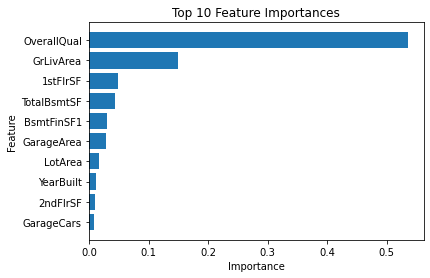

In [37]:
featureImportance = pd.DataFrame({"feature":treeXTrain.columns,
                                 "featureImportance":regr.feature_importances_},
                                columns = ["feature","featureImportance"])
featureImportanceSorted = featureImportance.sort_values(by="featureImportance")
topFeatureImportances = featureImportanceSorted.tail(10)
plt.figure()
plt.barh(topFeatureImportances["feature"], topFeatureImportances["featureImportance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances")
plt.savefig("../images/TreeFeatureImportances.jpg")

# Testing

In [38]:
if (("ISUDistance" not in housingTestWithoutDummies.columns) or 
    ("ISUDistance" not in housingTestWithDummies.columns)):
    housingTestWithoutDummies = util.returnDFWithISUDistance(housingTestWithoutDummies,True)
    housingTestWithDummies["ISUDistance"] = housingTestWithoutDummies["ISUDistance"]
    housingTestWithDummies.to_csv('../data/housingTestWithDummies.csv')
    housingTestWithoutDummies.to_csv('../data/housingTestWithoutDummies.csv')

In [39]:
housingTestNumerical = housingTestWithDummies.select_dtypes(include=['uint8','int64','float64'])
housingTestNumerical.drop(housingTestNumerical.filter(regex="Unname"),axis=1, inplace=True)
housingTestNumerical = util.replaceNansWithTrainingDataValues(housingTestNumerical)

/Users/garysimmons/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
../util/util.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(trainNanReplacementValuesDictionary[str(col)])


In [40]:
housingTestLinear = housingTestNumerical.copy()
housingTestForest = housingTestNumerical.copy()

## Linear Regression

In [41]:
housingTestLinear = pd.merge(housingTestLinear,housingTestWithDummies[["PID","Neighborhood"]],how='left', left_on='PID', right_on='PID')
joint_Nbr_quantile = pd.merge(housingTestLinear[['Neighborhood']], Nbr_quantile, how='left', left_on='Neighborhood', right_index=True)
smaller_home = housingTestLinear.GrLivArea < joint_Nbr_quantile.GrLivArea

small = []
large = []
for i,isSmall in enumerate(smaller_home):
    if isSmall:
        small.append(housingTestLinear.GrLivArea[i])
        large.append(0)
    else:
        small.append(0)
        large.append(housingTestLinear.GrLivArea[i])

housingTestLinear["smallGrLivArea^1.0"] = np.array(small) ** 1.0

housingTestLinear["largeGrLivArea^1.08"] = np.array(large) ** 1.08

In [42]:
xTest = housingTestLinear[["smallGrLivArea^1.0","largeGrLivArea^1.08"]]
xTrainColumns = xTrain.columns
for col in xTrainColumns:
    if (col in housingTestLinear.columns):
        xTest[col] = housingTestLinear[col]
    elif str(col) == 'KitchenAbvGr_invbc_l0.02_m-0.32_b13.92':
        xTest[col] = util.InvBoxCox(housingTestLinear['KitchenAbvGr'],
                                   0.02,-0.32,13.92)
    elif str(col) == 'BsmtHalfBath^0.7':
        xTest[col] = housingTestLinear['BsmtHalfBath'] ** 0.7
    elif str(col) == 'YrSold_invbc_l0.02_m-0.0_b18.25':
        xTest[col] = util.InvBoxCox(housingTestLinear['YrSold'],
                                   0.02,-0.0,18.25) 
    else:
        print(f'{col} not in housingTestLinear')
        break

<ipython-input-42-b7ec27f1c846>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xTest[col] = housingTestLinear[col]
<ipython-input-42-b7ec27f1c846>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xTest[col] = util.InvBoxCox(housingTestLinear['KitchenAbvGr'],
<ipython-input-42-b7ec27f1c846>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [43]:
linearTestSalesPrice = housingTestLinear['SalePrice']

linmodel = lm.LinearRegression()
linmodel.fit(xTrain,salesPrice)

linearTrainActual = salesPrice
linearTrainPredict = linmodel.predict(xTrain)
linearTestActual = linearTestSalesPrice
linearTestPredict = linmodel.predict(xTest)

linearTrainMSE = metrics.mean_squared_error(linearTrainActual,linearTrainPredict)
linearTestMSE = metrics.mean_squared_error(linearTestActual,linearTestPredict)

print(f'training mean sqauared error is {linearTrainMSE}')
print(f'testing mean squared error is {linearTestMSE}')

training mean sqauared error is 702320639.0471724
testing mean squared error is 638480078.5366304


## Random Forest

In [ ]:
yTestForest = housingTestForest["SalePrice"]
XTestForest = housingTestForest.drop(["SalePrice"],axis=1)

regr = RandomForestRegressor()
params = {'n_estimators': 1000, 'max_depth': 20, 'max_features': None}
regr = RandomForestRegressor(n_estimators=params["n_estimators"],
                            max_depth = params["max_depth"],
                            max_features = params["max_features"])
regr.fit(treeXTrain,treeSalesPrice)

treeTrainActual = treeSalesPrice
treeTrainPredict = regr.predict(treeXTrain)
treeTestActual = yTestForest
treeTestPredict = regr.predict(XTestForest)

treeTrainMSE = metrics.mean_squared_error(treeTrainActual,treeTrainPredict)
treeTestMSE = metrics.mean_squared_error(treeTestActual,treeTestPredict)

print(f'training mean sqauared error is {treeTrainMSE}')
print(f'testing mean squared error is {treeTestMSE}')

In [ ]:
finalScoreSeries = pd.Series({"linear regression train mse":linearTrainMSE,
          "linear regression test mse":linearTestMSE,
          "random forest regression train mse":treeTrainMSE,
          "random forest regression test mse":treeTestMSE})
finalScoreSeries

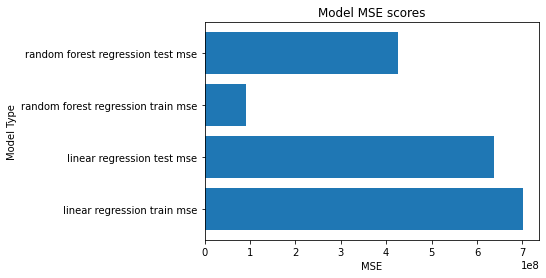

In [46]:
mseScores = np.array([linearTrainMSE,linearTestMSE,treeTrainMSE,treeTestMSE])
plt.figure()
plt.barh(finalScoreSeries.index,finalScoreSeries)
plt.xlabel("MSE")
plt.ylabel("Model Type")
plt.title("Model MSE scores")
plt.savefig("../images/MSEScores.jpg")